import json
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [2]:
filename = '21.json'

with open(filename) as f:
    input_data = json.load(f)

In [3]:
input_data

{'gamma_water': 1.0511348801388254,
 'md_vdp': 2932.001314672111,
 'd_tub': 0.7553834420073154,
 'angle': 56.147757343822356,
 'roughness': 0.0006238688585152281,
 'p_wh': 147.69704496763774,
 't_wh': 27.107279875142936,
 'temp_grad': 2.0185509758792737}

In [4]:
h = input_data['md_vdp'] # Глубина спуска НКТ, м
d_tub = input_data['d_tub'] / 10 # Диаметр НКТ, м

gamma_water = input_data['gamma_water'] # Относительная плотность воды, безразмерная

P_wh = input_data['p_wh'] * 0.101325 # Буферное давление, МПа
T_wh = input_data['t_wh'] + 273.15 # Температура жидкости у буферной линии, К

angle = input_data['angle'] # Угол наклона скважины к горизонтали
roughness = input_data['roughness'] # Шероховатость, м
t_grad = input_data['temp_grad'] # Температурный градиент

In [5]:
# Функция расчета температуры от глубины
h_md = np.linspace(0, h, 100) # h_md - глубина от 0 до глубины глубины спуска НКТ, м
temp = T_wh + h_md*t_grad / 100 # Температура в каждом интервале h_md
temp = interp1d(h_md, temp) 

In [6]:
def rho_w_kgm3(T_K, ws = 0):
    
    # Зависимость плотности от солености
    rho_w_sc_kgm3 = 1000 * (1.0009 - 0.7114 * ws + 0.2605 * ws**2)**(-1)
    
    # Зависимость плотности от температуры
    rho_w_kgm3 = rho_w_sc_kgm3 / (1 + (T_K - 273) / 10000 * (0.269 * (T_K - 273)**(0.637) - 0.8))
    
    return rho_w_kgm3

In [7]:
def salinity_gg(rho_kgm3):
    ws = 1/rho_kgm3*(1.36545*rho_kgm3-(3838.77*rho_kgm3-2.009*rho_kgm3**2)**0.5)
    # для плотности > 992 кг/м3
    if ws>0 :
        return ws
    else:
        return 0

In [8]:
def visc_w_cP(P_Mpa, T_K, ws = 0):
    A = 109.574 - 0.8406 * 1000 * ws + 3.1331 * 1000 * ws * ws + 8.7221 * 1000 * ws * ws * ws
    B = 1.1217 - 2.6396 * ws + 6.7946 * ws * ws + 54.7119 * ws * ws * ws - 155.586 * ws * ws * ws * ws
    muw = A * (1.8 * T_K - 460) ** (-B) * (0.9994 + 0.0058 * P_Mpa + 0.6534 * (10) ** (-4) * P_Mpa * P_Mpa)
    return muw

In [9]:
def Re(q_m3day, d_m, mu_mPas = 0.2, rho_kgm3 = 1000):
    # Расчет скорости потока [м/с]
    v_ms = q_m3day / 86400 / 3.1415 * 4 / d_m ** 2
    # Расчет числа Рейнольдса
    Re = rho_kgm3 * v_ms * d_m / mu_mPas * 1000
    return Re

In [10]:
def friction_Jain(q_m3day, d_m = 0.089, mu_mPas = 0.2, rho_kgm3 = 1000, roughness=0.000018):
    Re_val = Re(q_m3day,d_m,mu_mPas,rho_kgm3)
    
    # Ламинарный поток
    if Re_val < 3000:
        f = 64 / Re_val
        return f
    # Турбулентный поток
    else:
        f = 1 / (1.14 - 2 * np.log10(roughness / d_m + 21.25 / (Re_val**0.9)))**2
        return f

In [11]:
def friction_Churchill(q_m3day, d_m = 0.089, mu_mPas = 0.2, rho_kgm3 = 1000, roughness=0.000018):
    Re_val = Re(q_m3day,d_m,mu_mPas,rho_kgm3)
    A = (-2.457 * np.log((7 / Re_val)**(0.9) + 0.27*(roughness / d_m)))**16
    B = (37530 / Re_val)**16
    f = 8 * ((8 / Re_val)**12 + 1 / (A + B)**1.5)**(1 / 12)
    return f

In [12]:
# Функция расчета градиента давления [МПа/м]
def dp_dh(P_Mpa, h_m, q_m3day, d_m, angle, roughness, gamm_water):
    
    # Соленость воды, плотность которой дана по условию.Так как дана относительная, то умножаем на 1000
    sal_w = salinity_gg(gamm_water*1000)  
    T_K = temp(h_m) # Температура на каждой глубине
    rho = rho_w_kgm3(T_K, sal_w) # Плотность
    mu = visc_w_cP(P_Mpa, T_K) # Вязкость
    f = friction_Churchill(q_m3day, d_m, mu, rho, roughness) # Коэффициент трения
    
    dp_dl_grav = rho * 9.81 * mt.sin(angle * mt.pi / 180) # Потери давления гравитационные
    dp_dl_fric = f * rho * (q_m3day / 86400)** 2 / (d_m ** 5) # Потери давления из-за трения
    dp_dl = dp_dl_grav - (8 / mt.pi**2) * dp_dl_fric # Сумарные потери давления
    return dp_dl/1000000

In [13]:
# Зависимость забойного давления от расхода нагнетальной скважины (от 1 до 400 м3/сут)
q_inj_w = [1] + [i for i in range(0,410,10)][1:] # генерируем расход наг. скв. от 1 до 400
h_md = np.linspace(1, h, 60) 
delta_h = h_md[1] - h_md[0]
P_wf = []
for q in q_inj_w:
    P = [P_wh]
    for h_h in h_md:
        dp_dl = dp_dh(P[-1], h_h, q, d_tub, angle, roughness, gamma_water)
        delta_p = dp_dl * delta_h
        P.append(P[-1] + delta_p)
    P_wf.append(P[-1])

In [14]:
p_in_atm = list(np.array(P_wf)*9.8692327) # Перевод забойного давления в атмосферы

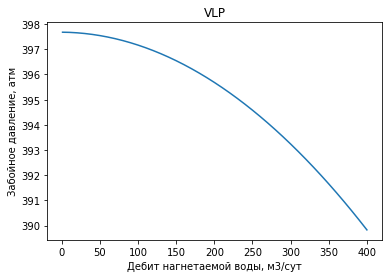

In [15]:
# График заивимости забойного давления от расхода воды нагнетательной скважины 
plt.title("VLP")
plt.xlabel('Дебит нагнетаемой воды, м3/сут')
plt.ylabel('Забойное давление, атм')
plt.plot( q_inj_w, p_in_atm)

In [16]:
dict_to_json = {"q": q_inj_w, "p_wf": p_in_atm} # q_liq - Расход, м3/сут; p_wf - Забойное давление, атм.

In [17]:
filename = 'output.json'
with open(filename, 'w') as f:
    json.dump(dict_to_json, f)